# 4.7 Physics-Informed Neural Networks


## 1. Introduction to Physics-Informed Neural Networks (PINNs)
Physics-Informed Neural Networks (PINNs) incorporate physical laws, expressed as partial differential equations (PDEs) or other governing equations, directly into the training of neural networks. By embedding the physics into the loss function, PINNs enable data-driven solutions while adhering to fundamental principles like conservation laws. They can:
* Solve PDEs with or without data.
* Require fewer labeled datasets since they rely on physics.
* Integrate prior knowledge into machine learning workflows.

Geosciences often rely on simulations governed by complex equations (e.g., Navier-Stokes, diffusion, or wave equations). PINNs provide a bridge between traditional computational modeling and machine learning, especially when data is scarce or noisy.
1. **Temperature Diffusion in Earth's Crust:**
   - Application in modeling geothermal energy potential.
   - Reference: Study on thermal conductivity prediction using sparse borehole data and PINNs.

2. **Seismic Wave Propagation:**
   - Real-time simulation of earthquake waves through heterogeneous media.
   - Reference: PINNs for solving elastic wave equations in complex geological domains.

3. **Groundwater Flow Dynamics:**
   - Modeling aquifer responses to pumping and recharge events. PINNs have helped solve the Darcy equation and advection-diffusion equations in hydrogeology to simulate groundwater movement and pollutant dispersion.

#### **Why PINNs in Geosciences?**
- Many geoscientific processes are governed by well-known PDEs (e.g., Navier-Stokes equations, heat diffusion equations).
- Combining sparse field data with known physical laws helps PINNs solve problems like seismic imaging, weather prediction, and subsurface modeling.

---

## 2. Mathematical Framework of PINNs
1. **Components of a PINN:**
   - Neural Network (NN): Approximates the solution \( u(x,t) \) or similar dependent variables.
   - PDE: The governing equation \( \mathcal{L}(u, x, t) = 0 \), where \( \mathcal{L} \) is the differential operator.
   - Loss Function:

     $\text{Loss} = \text{Data Loss} + \text{Physics Loss},$
     
     where
     - Data Loss enforces agreement with observations.
     - Physics Loss ensures the NN respects the governing equations.

2. **Optimization:**
   - Solve for NN parameters $\theta$ by minimizing the combined loss using gradient-based optimizers.

---

## 3. Python Example: Solving the Heat Equation with PyTorch
We will solve the **1D Heat Equation**:

$  \frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2},$

where $T(x,t)$ is temperature, $\alpha$ is the thermal diffusivity.

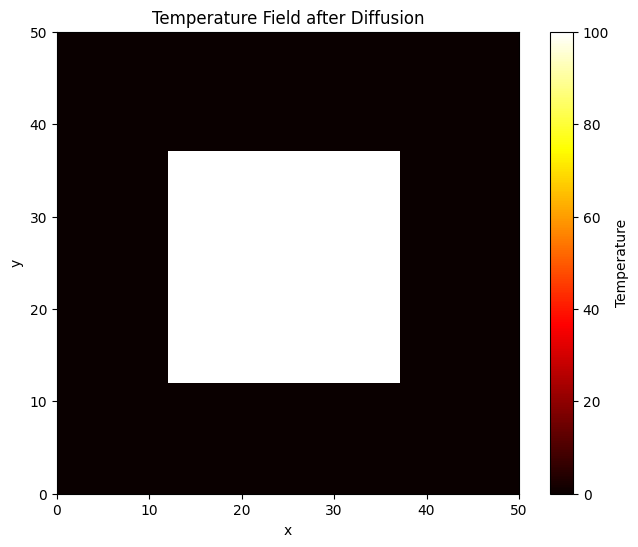

NameError: name 'sleep' is not defined

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
nx, ny = 50, 50  # Number of grid points in x and y directions
dx, dy = 1.0, 1.0  # Grid spacing in x and y directions
alpha = 0.01  # Thermal diffusivity
dt = 0.1  # Time step
nt = 100  # Number of time steps

# Initial temperature field
T = np.zeros((nx, ny))
T[nx//4:3*nx//4, ny//4:3*ny//4] = 100  # Initial heat source in the center

# Function to update the temperature field
def update_temperature(T, alpha, dx, dy, dt):
    T_new = T.copy()
    T_new[1:-1, 1:-1] = T[1:-1, 1:-1] + alpha * dt * (
        (T[2:, 1:-1] - 2 * T[1:-1, 1:-1] + T[:-2, 1:-1]) / dx**2 +
        (T[1:-1, 2:] - 2 * T[1:-1, 1:-1] + T[1:-1, :-2]) / dy**2
    )
    return T_new

# Time-stepping loop
for n in range(nt):
    T = update_temperature(T, alpha, dx, dy, dt)

    # Plot the final temperature field
    plt.figure(figsize=(8, 6))
    plt.imshow(T, extent=[0, nx*dx, 0, ny*dy], origin='lower', cmap='hot')
    plt.colorbar(label='Temperature')
    plt.title('Temperature Field after Diffusion')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    sleep(1)

In [1]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(10)

## Create Synthetic Data

A solution to this problem, given initial and boundary conditions at $T(x=0,t=0)T_0$, 

$ T(x,t) = T_0 \exp () $

First, we create synthetic, toy, noisy data.

In [2]:
def cooling_law(time, Tenv, T0, R):
    T = Tenv + (T0 - Tenv) * np.exp(-R * time)
    return T

Text(0.5, 0, 'Time (s)')

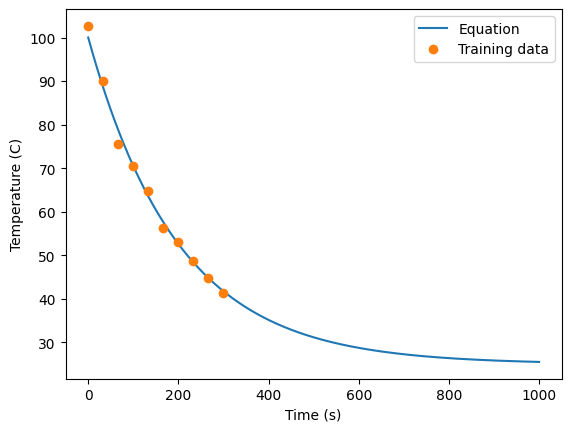

In [3]:
Tenv = 25
T0 = 100
R = 0.005
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, R=R)
temps = eq(times)

# Make training data
t = np.linspace(0, 300, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat




def np_to_th(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


def grad(outputs, inputs):
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )


class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))

Epoch 0/20000, loss: 4713.87
Epoch 2000/20000, loss: 2509.96
Epoch 4000/20000, loss: 2140.79
Epoch 6000/20000, loss: 724.98
Epoch 8000/20000, loss: 87.96
Epoch 10000/20000, loss: 1.94
Epoch 12000/20000, loss: 0.40
Epoch 14000/20000, loss: 0.35
Epoch 16000/20000, loss: 0.34
Epoch 18000/20000, loss: 0.33


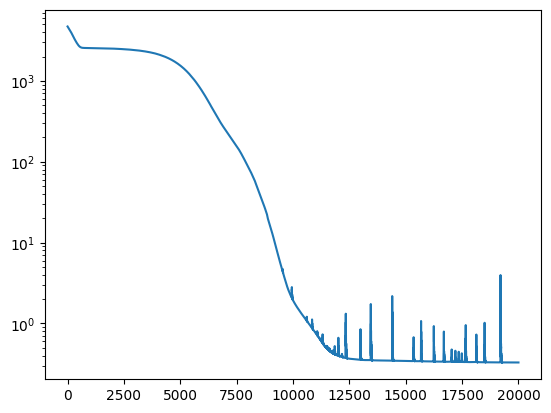

In [5]:
net = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)

plt.plot(losses)
plt.yscale('log')

In [6]:
# define the second loss function
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/20000, loss: 11220.99
Epoch 2000/20000, loss: 3922.64
Epoch 4000/20000, loss: 2426.29
Epoch 6000/20000, loss: 1615.85
Epoch 8000/20000, loss: 1198.53
Epoch 10000/20000, loss: 1020.56
Epoch 12000/20000, loss: 923.80
Epoch 14000/20000, loss: 848.24
Epoch 16000/20000, loss: 783.72
Epoch 18000/20000, loss: 719.29


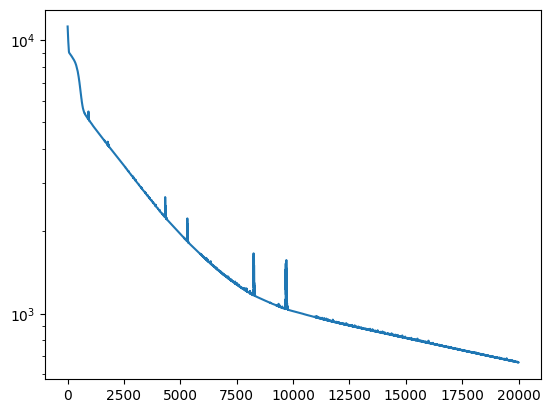

In [7]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

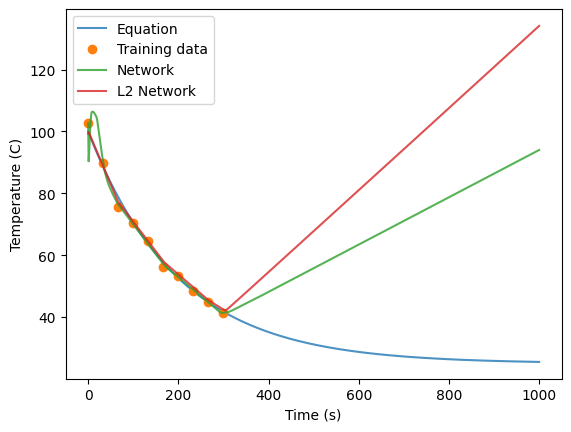

In [8]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## PINN

In [9]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4776.84
Epoch 3000/30000, loss: 2437.13
Epoch 6000/30000, loss: 556.53
Epoch 9000/30000, loss: 2.05
Epoch 12000/30000, loss: 1.41
Epoch 15000/30000, loss: 1.39
Epoch 18000/30000, loss: 1.36
Epoch 21000/30000, loss: 1.36
Epoch 24000/30000, loss: 1.33
Epoch 27000/30000, loss: 1.33


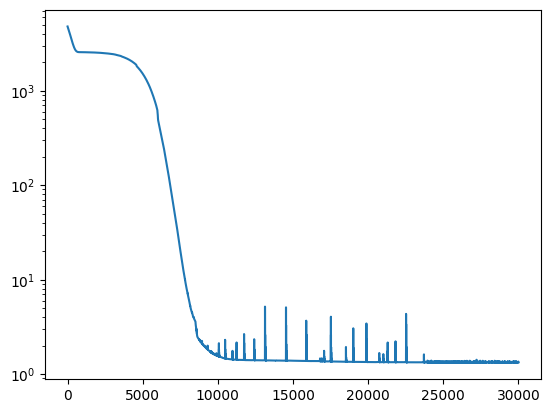

In [10]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')


Text(0.5, 0, 'Time (s)')

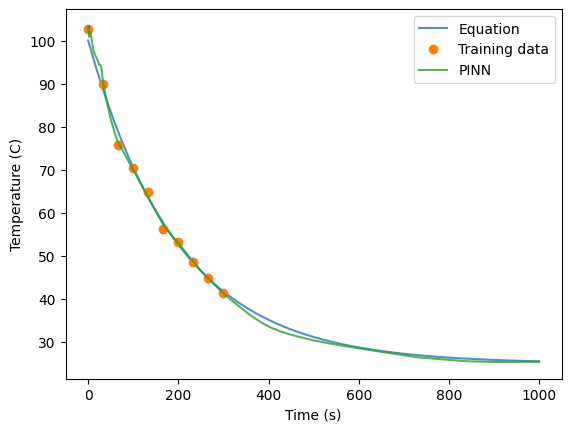

In [11]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')